# Parametric Poisson equation 

This notebook implements Poisson equation where diffusivity is uncertain and sampled from log-normal like distribution. Dependencies are mentioned in the `neuralop.yml` file in the root directory of this repository. 

## Problem description
Consider a two dimensional domain $\Omega = (0, 1) \times (0, 1) \subset \mathbb{R}^2$ and suppose $u: \Omega \to \mathbf{R}$ denotes the temperature field. The balance of energy governs it via the differential equation:
\begin{equation}\tag{1}
    \begin{aligned}
        -\nabla \cdot \left( m(x) \nabla u(x) \right) &= f(x)\,, \qquad &\forall x \in \Omega\,, \\
        u(x) &= 0\,, \qquad &\forall x \in \Gamma_u\,, \\
        m(x) \nabla u(x)\cdot n(x) &= q(x)\,, \qquad & \forall x \in \Gamma_q\,,
    \end{aligned}
\end{equation}
where $\Gamma_u:= \left\{ x \in \partial \Omega: x_1 < 1 \right\}$ (i.e., all sides except the right side of the rectangular domain) and $\Gamma_q:= \partial \Omega - \Gamma_u$. We let
\begin{equation}\tag{2}
    f(x) = 1000 (1-x_2)x_2(1 - x_1)(1 - x_1) \qquad \text{and} \qquad q(x) = 50\sin(5\pi x_2)\,.
\end{equation}

The probability distribution for $m$ is given by
\begin{equation}\tag{3}
    m = \alpha_m * \log(w) + \mu_m, \qquad \text{where} \quad w \sim N(0, C)\,,
\end{equation}
where $N(0, C)$ denotes the Gaussian normal distribution with the mean function being zero in $L^2(\Omega, \mathbb{R})$ and $C: L^2(\Omega; \mathbb{R}) \times L^2(\Omega; \mathbb{R})\to \mathbb{R}$ a covariance operator taking the form:
\begin{equation}
    C = \begin{cases}\tag{3}
        (-\gamma_C \nabla \cdot \nabla + \delta_C)^{-d_C}\,, \qquad & \text{in } \Omega\,,\\
        \gamma_C n \cdot \nabla + \eta_C\,, \qquad & \text{on }\partial \Omega\,,
    \end{cases}
\end{equation}
with $\gamma_C, \delta_C, \eta_C, d_C$ being the parameters of a covariance operator and $n$ unit outward normal. We fix the following values of distribution parameters
\begin{equation}\tag{4}
\gamma_C = 0.8\,, \quad \delta_C = 0.2\,,\quad \eta_C = 1\,,\quad  d_C = 2\,, \quad \alpha_m = 1\,, \quad \beta_m = 1\,.
\end{equation}

Given $m\in M$, we let $F(m) = u\in U$ be the solution of boundary value problem (BVP) Eq (1), i.e., $F: M \to U$ is the solution/forward operator. 

## Random samples of m and corresponding solution u(m)

<p align="center"> <img src="./data/Poisson_sample_plots.png" width="400"> </p>

In [8]:
import sys
import os
import time
import numpy as np
import dolfin as dl
import hippylib as hp

from scipy.interpolate import griddata

util_path = "../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)

In [9]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Plotting functions

In [10]:
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [11]:
def field_plot_fenics(ax, f, Vh, \
                      plot_absolute = False, \
                      add_displacement_to_nodes = False, \
                      is_displacement = False, \
                      is_fn = False, dbg_log = False, **kwargs):
    
    if is_fn:
        f_fn = f
    else:
        f_fn = dl.Function(Vh)
        f_fn.vector().zero()
        if isinstance(f, np.ndarray):
            f_fn.vector().set_local(f)
        else:
            f_fn.vector().axpy(1.0, f)
    
    mesh = Vh.mesh()
    gdim = mesh.geometry().dim()

    if gdim != 2:
        raise ValueError("Only 2D plots are supported")

    w0 = f_fn.compute_vertex_values(mesh)
    nv = mesh.num_vertices()

    U = [w0[i * nv: (i + 1) * nv] for i in range(gdim)]
    
    if gdim == 2:
        if len(U[gdim - 1]) == 0:
            U = np.array(U[0]).T
        else:
            U = np.array(U).T
    else:
        U = np.array(U).T

    n1, n2 = U.shape[0], 1 if len(U.shape) == 1 else U.shape[1]
    if dbg_log:
        print('n1, n2 = {}, {}'.format(n1, n2))

    nodes = mesh.coordinates()
    elements = mesh.cells()

    # Compute magnitude of the field
    plot_C = None
    if len(U.shape) == 1:
        plot_C = np.sqrt(U[:]**2) if plot_absolute else U[:]
    else:
        for i in range(n2):
            if i == 0:
                plot_C = U[:, i]**2
            else:
                plot_C += U[:, i]**2

        plot_C = np.sqrt(plot_C)

    # manipulate the configuration of the plot
    nodes_def = nodes
    if is_displacement:
        if n2 != 2:
            raise ValueError("Displacement should be a 2D array for dim = 2")

        if add_displacement_to_nodes:
            nodes_def = nodes + U

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1], elements)
    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'
    cbar = ax.tripcolor(triang, plot_C, shading=shading, **kwargs)

    return cbar

In [34]:
def field_plot(ax, fn_nodal_values, nodes, elements = None, dim = 2, \
                        plot_absolute = False, \
                        add_displacement_to_nodes = False, \
                        is_displacement = False, \
                        dbg_log = False, **kwargs):
    
    if dim != 2:
        raise ValueError("Only 2D plots are supported")
    
    if dbg_log:
        print('fn_nodal_values.shape = {}, nodes.shape = {}'.format(fn_nodal_values.shape, \
                                                                nodes.shape))
    
    num_nodes = nodes.shape[0]
    num_fn_values = fn_nodal_values.shape[0]

    dof_per_node = num_fn_values // num_nodes
    if dof_per_node == 0:
        raise ValueError("Number of dofs per node is zero")

    # Compute magnitude of the field
    plot_C = None
    if dof_per_node == 1:
        plot_C = np.sqrt(fn_nodal_values[:]**2) if plot_absolute else fn_nodal_values[:]
    else:
        for i in range(dof_per_node):
            if i == 0:
                plot_C = fn_nodal_values[i*num_nodes:(i+1)*num_nodes]**2
            else:
                plot_C += fn_nodal_values[i*num_nodes:(i+1)*num_nodes]**2

        plot_C = np.sqrt(plot_C)

    # do we warp the configuration of domain (i.e., displace the nodal coordinates)?
    nodes_def = nodes.copy()
    if is_displacement:
        if dof_per_node != 2:
            raise ValueError("Expected a vector function")

        if add_displacement_to_nodes:
            nodes_def[:, 0] = nodes[:, 0] + fn_nodal_values[0:num_nodes]
            nodes_def[:, 1] = nodes[:, 1] + fn_nodal_values[num_nodes:2*num_nodes]

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = None
    if elements is not None:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1], elements)
    else:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1])

    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'

    cbar = ax.tripcolor(triang, plot_C, shading=shading, **kwargs)

    return cbar

In [ ]:
def field_plot_grid(ax, fn_nodal_values, grid_x, grid_y, dim = 2, \
                        plot_absolute = False, \
                        add_displacement_to_nodes = False, \
                        is_displacement = False, \
                        dbg_log = False, **kwargs):
    if dim != 2:
        raise ValueError("Only 2D plots are supported")
    
    # grid_x and grid_y are of shape (nx, ny)
    # fn_nodal_values is of shape (nx, ny) if scalar and (nx, ny, 2) if vector
    nx, ny = grid_x.shape[0], grid_x.shape[1]
    n_comps = 1 if len(fn_nodal_values.shape) == 2 else fn_nodal_values.shape[2]
    if dbg_log:
        print('nx = {}, ny = {}, n_comps = {}'.format(nx, ny, n_comps))

    # we reduce the grid_x and grid_y to 1D arrays and then stack them together
    nodes = np.vstack((grid_x.flatten(), grid_y.flatten())).T
    if dbg_log:
        print('nodes.shape = {}'.format(nodes.shape))

    # also reduce the fn_nodal_values to 1D array
    if n_comps == 1:
        fn_nodal_values = fn_nodal_values.flatten()
    else:
        fn_nodal_values = fn_nodal_values.reshape((nx*ny, n_comps))
    
    # Compute magnitude of the field
    plot_C = None
    if n_comps == 1:
        plot_C = np.sqrt(fn_nodal_values[:]**2) if plot_absolute else fn_nodal_values[:]
    else:
        for i in range(n_comps):
            if i == 0:
                plot_C = fn_nodal_values[:, i]**2
            else:
                plot_C += fn_nodal_values[:, i]**2

        plot_C = np.sqrt(plot_C)

    # manipulate the configuration of the plot
    nodes_def = nodes
    if is_displacement and add_displacement_to_nodes:
        if n_comps != 2:
            raise ValueError("Displacement should be a 2D array for dim = 2")

        nodes_def = nodes + fn_nodal_values

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1])

    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'

    cbar = ax.tripcolor(triang, plot_C, shading=shading, **kwargs)

    return cbar

In [ ]:
def plot_samples(m_vec, u_vec, nodes, u_tag, \
                save_fig = False, \
                save_fname = None):
    rows = len(m_vec)
    cols = 2
    fs = 20
    fig, axs = plt.subplots(rows, cols, figsize=(8, 12))

    cmap_vec = ['jet', 'viridis']

    for i in range(rows):

        for j in range(cols):
            if j == 0:
                cbar = field_plot(axs[i,j], m_vec[i], nodes, cmap = cmap_vec[j])
            else:
                cbar = field_plot(axs[i,j], u_vec[i], nodes, cmap = cmap_vec[j])

            divider = make_axes_locatable(axs[i,j])
            cax = divider.append_axes('right', size='8%', pad=0.03)
            cax.tick_params(labelsize=fs)

            if j== 0:
                # format cbar ticks
                kfmt = lambda x, pos: "{:g}".format(x)
                
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
            else:
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
            
            if i == 0:
                axs[i,j].set_title(u_tag[j], fontsize=fs)
            axs[i,j].axis('off')
        
    fig.tight_layout()
    fig.suptitle('Samples of m and corresponding u(m)', fontsize=1.25*fs, y=1.025)
    if save_fig:
        fig.savefig(save_fname,  bbox_inches='tight')

    plt.show()


def plot_samples_grid(m_vec, u_vec, grid_x, grid_y, u_tag, \
                save_fig = False, \
                save_fname = None):
    rows = len(m_vec)
    cols = 2
    fs = 20
    fig, axs = plt.subplots(rows, cols, figsize=(8, 12))

    cmap_vec = ['jet', 'viridis']

    for i in range(rows):

        for j in range(cols):
            if j == 0:
                cbar = field_plot_grid(axs[i,j], m_vec[i], \
                                       grid_x, grid_y, cmap = cmap_vec[j])
            else:
                cbar = field_plot_grid(axs[i,j], u_vec[i], \
                                       grid_x, grid_y, cmap = cmap_vec[j])

            divider = make_axes_locatable(axs[i,j])
            cax = divider.append_axes('right', size='8%', pad=0.03)
            cax.tick_params(labelsize=fs)

            if j== 0:
                # format cbar ticks
                kfmt = lambda x, pos: "{:g}".format(x)
                
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
            else:
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
            
            if i == 0:
                axs[i,j].set_title(u_tag[j], fontsize=fs)
            axs[i,j].axis('off')
        
    fig.tight_layout()
    fig.suptitle('Samples of m and corresponding u(m)', fontsize=1.25*fs, y=1.025)
    if save_fig:
        fig.savefig(save_fname,  bbox_inches='tight')

    plt.show()

# Main model class
This will be ultimately moved to a python script but for now we will keep it here for testing purposes. The class has two component: (1) class to sample diffusivity field using log-normal distribution in infinite dimension and (2) class that implements the variational form and solves it. 

In [ ]:
class PriorSamplerHP:

    def __init__(self, Vm, correlation_length, seed = 0, logn_scale = 1., logn_translate = 1.):
        self.correlation_length = correlation_length
        var = self.correlation_length / 0.16
        # Delta and gamma
        self.delta = (var * self.correlation_length) ** (-0.5)
        self.gamma = self.delta * self.correlation_length ** 2

        self.seed = seed
        self.Vm = Vm

        self.prior = hp.BiLaplacianPrior(self.Vm, self.gamma, self.delta, robin_bc=True)
        self.translate = dl.Constant(logn_translate)
        self.scale = dl.Constant(logn_scale)
        
        self.parRandom = hp.Random(seed = seed)

        # initialize noise vector
        self.noise = dl.Vector()
        self.prior.init_vector(self.noise, "noise")
        self.parRandom.normal(1.,self.noise)
        
        # initialize sample
        self.sample = dl.Vector()
        self.prior.init_vector(self.sample, 0)

        # draw a sample
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.m_local = None
        self.m_fn = dl.Function(self.Vm)
        self.m_transform_fn = dl.Function(self.Vm)

        # set mean
        self.mean = self.prior.mean.copy()
        self.transform(self.mean)

    def transform(self, m):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., m)
        self.m_transform_fn = self.scale * dl.exp(self.m_fn) + self.translate
        
        self.m_local = dl.project(self.m_transform_fn, self.Vm).vector().get_local()
        m.set_local(self.m_local)


    def transform_pointwise(self, m):
        self.m_local = self.scale.values()[0]*np.exp(m.get_local()) + self.translate.values()[0]
        m.set_local(self.m_local)

    def get(self):
        self.sample.zero()
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.transform_pointwise(self.sample)
        return self.sample
    
class PoissonModel:
    
    def __init__(self, correlation_length, seed = 0):
        
        # FE setup
        self.fe_order = 1
        self.nx = 50
        self.ny = 50
        self.mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), self.nx, self.ny)
        self.Vu = dl.FunctionSpace(self.mesh, "Lagrange", self.fe_order)
        self.Vm = self.Vu
        self.Vh = [self.Vu, self.Vm, self.Vu] # state, parameter, adjoint

        # Boundary conditions
        self.f = dl.Expression("1000*(1-x[1])*x[1]*(1-x[0])*(1-x[0])", degree=2)
        self.q = dl.Expression("50*sin(5*pi*x[1])", degree=2)

        # variational form
        self.m_fn = dl.Function(self.Vm)
        self.u_fn = dl.Function(self.Vu)
        
        self.u_trial = dl.TrialFunction(self.Vu)
        self.u_test = dl.TestFunction(self.Vu)
        self.a = self.m_fn*dl.inner(dl.nabla_grad(self.u_trial), dl.nabla_grad(self.u_test))*dl.dx 
        self.L = self.f*self.u_test*dl.dx \
                 + self.q*self.u_test*dl.ds # boundary term
        self.varf = self.a - self.L
        
        self.bc = [dl.DirichletBC(self.Vu, dl.Constant(0), self.boundaryU)]

        # setup prior for parameter field m
        self.prior_sampler = PriorSamplerHP(self.Vm, correlation_length, seed)
        
    @staticmethod
    def boundaryU(x, on_boundary):
        return on_boundary and x[0] < 1. - dl.DOLFIN_EPS
    
    def boundaryU_all_nodes(self, x):
        boundary_nodes = []
        for i in range(x.shape[0]):
            if np.abs(x[i,0] - 1) < dl.DOLFIN_EPS:
                boundary_nodes.append(i)
        return np.array(boundary_nodes)

    def solveFwd(self, m = None, m_is_fn = True):
        if m is not None:
            self.m_fn.vector().zero()
            if m_is_fn:
                self.m_fn.vector().axpy(1., m.vector())
            else:
                self.m_fn.vector()[:] = m


        self.A = dl.assemble(self.a)
        self.b = dl.assemble(self.L)
        for bc in self.bc:
            bc.apply(self.A, self.b)
        
        dl.solve(self.A, self.u_fn.vector(), self.b)

    def samplePrior(self):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., self.prior_sampler.get())

# Test Poisson model

In [ ]:
correlation_length = 2
model_name = 'Poisson'
model = PoissonModel(correlation_length)
print(model.prior_sampler.gamma, model.prior_sampler.delta)

0.8 0.2


## Generate few samples of diffusivity and solve the forward problem

In [ ]:
n_test_samples = 4

m_fn = dl.Function(model.Vm)
u_fn = dl.Function(model.Vu)

m_vec = []
u_vec = []

for i in range(n_test_samples):

    m_fn.vector().zero()
    if i > 0:
        m_fn.vector().axpy(1., model.prior_sampler.get())
    else:
        m_fn.vector().axpy(1., model.prior_sampler.mean)
    
    model.solveFwd(m_fn, m_is_fn = True)
    u_fn = model.u_fn

    m_vec.append(m_fn.compute_vertex_values())
    u_vec.append(u_fn.compute_vertex_values())

plot_samples(m_vec, u_vec, model.mesh.coordinates(), u_tag = ['m', 'u(m)'])

u_vv shape = (2601,)


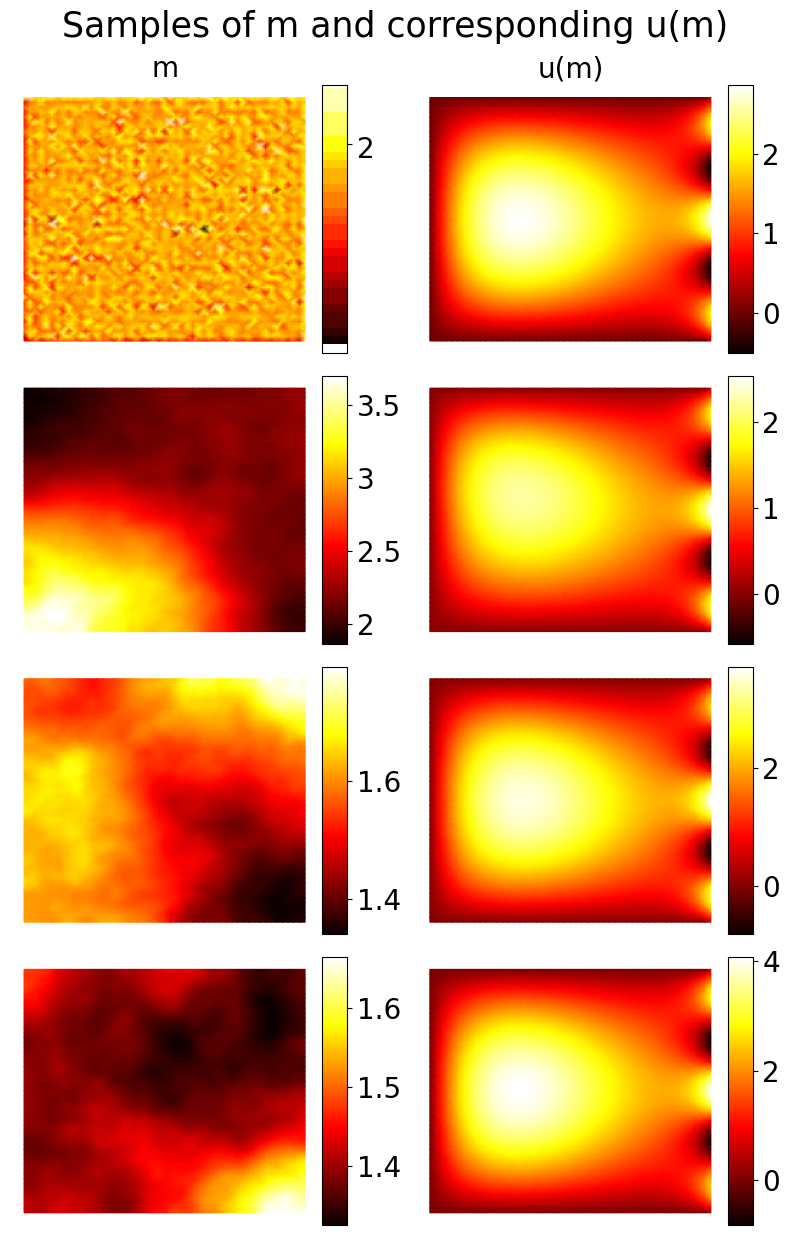

In [ ]:
a = model.prior_sampler.mean.get_local()
print('mean:', a.mean(), a.min(), a.max())
a = model.prior_sampler.get().get_local()
print('sample:', a.mean(), a.min(), a.max())

## Locate the nodes on the Dirichlet boundary

In [ ]:
u_mesh_nodes = model.Vu.mesh().coordinates()
u_mesh_boundary_nodes = model.boundaryU_all_nodes(u_mesh_nodes)

print(u_mesh_boundary_nodes.shape, u_mesh_boundary_nodes)

## Generate data

In [ ]:
generate_data = True
if generate_data:
    num_samples = 2000

    m_samples = np.zeros((num_samples, model.Vm.dim()))
    u_samples = np.zeros((num_samples, model.Vu.dim()))

    m_fn = dl.Function(model.Vm)
    u_fn = dl.Function(model.Vu)

    for i in range(num_samples):

        start_time = time.perf_counter()

        m_fn.vector().zero()
        if i > 0:
            m_fn.vector().axpy(1., model.prior_sampler.get())
        else:
            m_fn.vector().axpy(1., model.prior_sampler.mean)
        
        model.solveFwd(m_fn, m_is_fn = True)
        u_fn = model.u_fn

        # save
        m_samples[i, :] = m_fn.compute_vertex_values()
        u_samples[i, :] = u_fn.compute_vertex_values()

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(m_samples.shape, u_samples.shape)

Sample    0 took 0.060 seconds
Sample  100 took 0.031 seconds
Sample  200 took 0.029 seconds
Sample  300 took 0.029 seconds
Sample  400 took 0.028 seconds
Sample  500 took 0.023 seconds
Sample  600 took 0.030 seconds
Sample  700 took 0.030 seconds
Sample  800 took 0.036 seconds
Sample  900 took 0.024 seconds
Sample 1000 took 0.024 seconds
Sample 1100 took 0.028 seconds
Sample 1200 took 0.024 seconds
Sample 1300 took 0.028 seconds
Sample 1400 took 0.029 seconds
Sample 1500 took 0.042 seconds
Sample 1600 took 0.054 seconds
Sample 1700 took 0.027 seconds
Sample 1800 took 0.026 seconds
Sample 1900 took 0.053 seconds
(2000, 2601) (2000, 2601)


In [ ]:
if generate_data:    
    # plot 4 samples randomly chosen from the data
    i_choices = np.random.choice(num_samples, 4, replace=False)
    m_vec = [m_samples[i, :] for i in i_choices]
    u_vec = [u_samples[i, :] for i in i_choices]
    
    plot_samples(m_vec, u_vec, model.mesh.coordinates(), \
                u_tag = ['m', 'u(m)'], \
                save_fig = True, \
                save_fname = results_dir + data_prefix + '_sample_plots.png')

In [ ]:
if generate_data:
    # data to save
    np.savez(results_dir + data_prefix + '_samples.npz', \
            m_samples = m_samples, \
            u_samples = u_samples, num_samples = num_samples, \
            m_dim = model.Vm.dim(), u_dim = model.Vu.dim(), \
            fe_order = model.fe_order, nx = model.nx, ny = model.ny, \
            correlation_length = correlation_length, \
            gamma = model.prior_sampler.gamma, \
            delta = model.prior_sampler.delta, \
            alpha_m = model.prior_sampler.scale.values()[0], \
            mu_m = model.prior_sampler.translate.values()[0], \
            u_mesh_nodes = model.Vu.mesh().coordinates(), \
            m_mesh_nodes = model.Vm.mesh().coordinates(), \
            u_mesh_elements = model.Vu.mesh().cells(), \
            m_mesh_elements = model.Vm.mesh().cells(), \
            u_mesh_boundary_nodes = model.boundaryU_all_nodes(u_mesh_nodes))


    # save mesh 
    ## to read, use the syntax
    ## mesh = dl.Mesh()
    ## with dl.XDMFFile(results_dir + 'u_mesh.xdmf') as infile:
    ##     infile.read(mesh)
    with dl.XDMFFile(results_dir + data_prefix + '_u_mesh.xdmf') as infile:
        infile.write(model.Vu.mesh())

    with dl.XDMFFile(results_dir + data_prefix + '_m_mesh.xdmf') as infile:
        infile.write(model.Vm.mesh())

m_mesh_nodes shape: (2601, 2)
u_mesh_nodes shape: (2601, 2)
m_dim: 2601
u_dim: 2601


In [ ]:
print('m_mesh_nodes shape: {}\nu_mesh_nodes shape: {}\nm_dim: {}\nu_dim: {}'.format(model.Vm.mesh().coordinates().shape, model.Vu.mesh().coordinates().shape, model.Vm.dim(), model.Vu.dim()))

## Interpolate function at nodal values to meshgrid for FNO

### Compute and plot interpolation over grid

[]

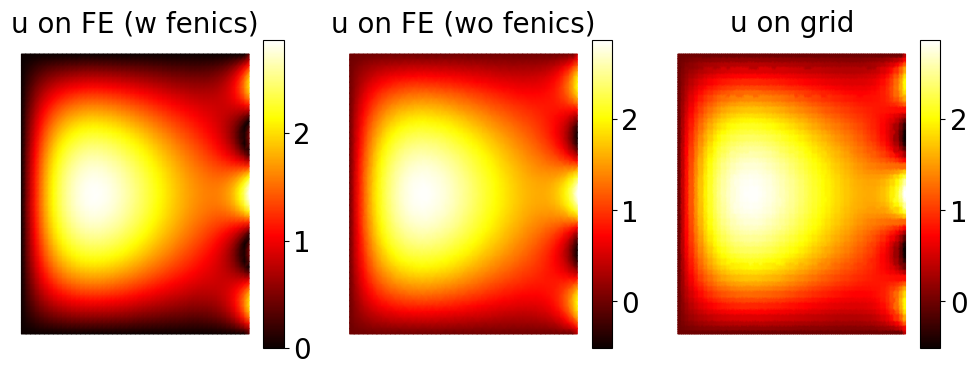

In [ ]:
data_load = np.load(results_dir + data_prefix + '_samples.npz')
fe_u_nodes = data_load['u_mesh_nodes']
fe_m_nodes = data_load['m_mesh_nodes']

# get one sample
m_fn = dl.Function(model.Vm)
m_fn.vector().axpy(1., model.prior_sampler.mean)
model.solveFwd(m_fn, m_is_fn = True)
u_fn = model.u_fn

m = m_fn.compute_vertex_values(model.Vm.mesh())
u = u_fn.compute_vertex_values(model.Vu.mesh())

# use interpolation to get data on grid
num_grid_x, num_grid_y = 121, 121
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y))

# interpolate m and u on grid
grid_m = griddata(fe_m_nodes, m, (grid_x, grid_y), method='linear')
grid_u = griddata(fe_u_nodes, u, (grid_x, grid_y), method='linear')

# plot function on FE mesh and compare with the function on grid

rows = 1
cols = 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(24, 6))

for i in range(cols):
    
    if i%2 == 0:
        # use plotter without element data
        if i == 0:
            cbar = field_plot(axs[i], m, fe_m_nodes, cmap = 'jet')
            axs[i].set_title('m on FE mesh', fontsize = fs)
        else:
            cbar = field_plot(axs[i], u, fe_u_nodes, cmap = 'viridis')
            axs[i].set_title('u(m) on FE mesh', fontsize = fs)
    else:
        # use griddata
        if i == 1:
            cbar = field_plot_grid(axs[i], grid_m, grid_x, grid_y, cmap = 'jet')
            axs[i].set_title('m on grid mesh', fontsize = fs)
        else:
            cbar = field_plot_grid(axs[i], grid_u, grid_x, grid_y, cmap = 'viridis')
            axs[i].set_title('u(m) on grid mesh', fontsize = fs)

    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='8%', pad=0.03)
    cax.tick_params(labelsize=fs)

    if i < 2:
        # format cbar ticks
        kfmt = lambda x, pos: "{:g}".format(x)
        
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
    else:
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

    axs[i].axis('off')

fig.tight_layout()
fig.suptitle('Compare (m,u) on FE and grid mesh', fontsize=1.25*fs, y=1.075)
fig.savefig(results_dir + data_prefix + '_compare_FE_and_grid_mesh.png',  bbox_inches='tight')
plt.show()


### Interpolate all samples to grid and save to file for FNO

In [ ]:
# save all samples to file
generate_fno_data = True
if generate_fno_data:

    num_grid_x, num_grid_y = 121, 121
    print('Generating FNO data for grid sizes ({}, {})'.format(num_grid_x, num_grid_y))

    # get grid coordinates
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y))

    # load data
    data_load = np.load(results_dir + data_prefix + '_samples.npz')
    
    fe_m_nodes = data_load['m_mesh_nodes']
    fe_u_nodes = data_load['u_mesh_nodes']

    m_samples = data_load['m_samples']
    u_samples = data_load['u_samples']

    num_samples = m_samples.shape[0]
    
    # interpolate samples on grid
    grid_m_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    grid_u_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    for i in range(num_samples):
        start_time = time.perf_counter()
        
        grid_m_samples[i, :, :] = griddata(fe_m_nodes, m_samples[i, :], (grid_x, grid_y), method='linear')
        grid_u_samples[i, :, :] = griddata(fe_u_nodes, u_samples[i, :], (grid_x, grid_y), method='linear')

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(grid_m_samples.shape, grid_u_samples.shape)

Generating FNO data for grid sizes (121, 121)
Sample    0 took 0.068 seconds
Sample  100 took 0.075 seconds
Sample  200 took 0.074 seconds
Sample  300 took 0.066 seconds
Sample  400 took 0.066 seconds
Sample  500 took 0.066 seconds
Sample  600 took 0.067 seconds
Sample  700 took 0.078 seconds
Sample  800 took 0.073 seconds
Sample  900 took 0.072 seconds
Sample 1000 took 0.063 seconds
Sample 1100 took 0.066 seconds
Sample 1200 took 0.070 seconds
Sample 1300 took 0.075 seconds
Sample 1400 took 0.065 seconds
Sample 1500 took 0.071 seconds
Sample 1600 took 0.067 seconds
Sample 1700 took 0.067 seconds
Sample 1800 took 0.073 seconds
Sample 1900 took 0.063 seconds
(2000, 121, 121) (2000, 121, 121)


In [ ]:
if generate_fno_data:    
    # plot 4 samples randomly chosen from the data
    i_choices = np.random.choice(num_samples, 4, replace=False)
    m_vec = [grid_m_samples[i, :, :] for i in i_choices]
    u_vec = [grid_u_samples[i, :, :] for i in i_choices]

    for i in range(len(i_choices)):
        print('m_vec shape: {}\nu_vec shape: {}'.format(m_vec[i].shape, u_vec[i].shape))
    
    plot_samples_grid(m_vec, u_vec, grid_x, grid_y, \
                u_tag = ['m', 'u(m)'], \
                save_fig = True, \
                save_fname = \
                    results_dir + data_prefix + '_sample_plots_on_grid.png')

In [ ]:
# data to save
if generate_fno_data:
        np.savez(results_dir + data_prefix + '_FNO_samples.npz', \
                grid_m_samples = grid_m_samples, \
                grid_u_samples = grid_u_samples, \
                num_samples = num_samples, \
                num_grid_x = num_grid_x, num_grid_y = num_grid_y, \
                grid_x = grid_x, grid_y = grid_y)

### Load data to test

In [ ]:
data_load = np.load(results_dir + data_prefix + '_samples.npz')

print('num_samples: {}\nm_samples shape: {}\nu_samples shape: {}\nm_dim: {}\nu_dim: {}'.format(data_load['num_samples'], data_load['m_samples'].shape, data_load['u_samples'].shape, data_load['m_dim'], data_load['u_dim']))

num_samples: 2000
m_samples shape: (2000, 2601)
u_samples shape: (2000, 2601)
m_dim: 2601
u_dim: 2601


In [ ]:
data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')
print('num_samples: {}\ngrid_m_samples shape: {}\ngrid_u_samples shape: {}'.format(data_load['num_samples'], data_load['grid_m_samples'].shape, data_load['grid_u_samples'].shape))